# China/PLP trocas comerciais

Ver [cn_plp_import_export_README.md](cn_plp_import_export_README.md) para detalhes sobre a coleta de dados.

## Inicialização

Antes de executar este notebook pela primeira é necessário obter uma APIKEY da base de dados Comtrade.
A APIKEY que dá acesso a mais de 500 linhas de
resultados.

Ver [aqui](0-comtrade-setup-first.ipynb) para instruções como obter chave de acesso APIKEY e
guardá-la no ficheiro de configuração.



In [1]:

import comtradetools as comtradetools

comtradetools.setup()
APIKEY = comtradetools.get_api_key()


## Parâmetros gerais que não mudam



In [1]:
from comtradetools import encode_country
from comtradetools import COUNTRY_CODES_REVERSE as m49

angola = encode_country('Angola')
brazil = encode_country('Brazil')
cabo_verde = encode_country('Cabo Verde')
china = encode_country('China')
hong_kong = encode_country('China, Hong Kong SAR')
macau = encode_country('China, Macao SAR')
taiwan = encode_country('Taiwan, Province of China')
guine_equatorial = encode_country('Equatorial Guinea')
guine_bissau = encode_country('Guinea-Bissau')
mozambique = encode_country('Mozambique')
portugal = encode_country('Portugal')
stome_principe = encode_country('Sao Tome and Principe')
timor = encode_country('Timor-Leste')

# make list of Portuguese Speaking Countries
plp = [angola, brazil, cabo_verde, guine_bissau,
       guine_equatorial, mozambique, portugal,
       stome_principe, timor]
plp_list = ",".join(map(str, plp))



## Parâmetros para visualização

### Descrição das colunas devolvidas pela API Comtrade

In [16]:
import comtradetools as comtrade

print(comtrade.DATA_ITEM_DF.to_markdown())


|    | dataItem                 | description                                                                              | isInDataAPICommodity   | isInDataAPIServices   | isInBulkFileFinal   | isInBulkFileTariffline   |
|---:|:-------------------------|:-----------------------------------------------------------------------------------------|:-----------------------|:----------------------|:--------------------|:-------------------------|
|  0 | datasetCode              | Combination of several keys to identify specific datasetCode                             | True                   | True                  | True                | True                     |
|  1 | typeCode                 | Product type: Goods or Services                                                          | True                   | True                  | True                | True                     |
|  2 | freqCode                 | The time interval at which observations occur                             

Lista de colunas

In [6]:
import comtradetools as comtrade

cols_all = comtrade.DATA_ITEM_DF.dataItem.unique()
cols_all

array(['datasetCode', 'typeCode', 'freqCode', 'refPeriodId', 'refYear',
       'refMonth', 'period', 'reporterCode', 'reporterISO',
       'reporterDesc', 'flowCategory', 'flowCode', 'flowDesc',
       'partnerCode', 'partnerISO', 'partnerDesc', 'partner2Code',
       'partner2ISO', 'partner2Desc', 'classificationSearchCode',
       'classificationCode', 'isOriginalClassification', 'cmdCode',
       'cmdDesc', 'aggrLevel', 'isLeaf', 'customsCode', 'customsDesc',
       'mosCode', 'mosDesc', 'motCode', 'motDesc', 'qtyUnitCode',
       'qtyUnitAbbr', 'qty', 'isQtyEstimated', 'altQtyUnitCode',
       'altQtyUnitAbbr', 'altQty', 'isAltQtyEstimated', 'netWgt',
       'isnetWgtEstimated', 'grossWgt', 'isgrossWgtEstimated', 'cifValue',
       'fobValue', 'primaryValue', 'legacyEstimationFlag', 'isReported',
       'isAggregate'], dtype=object)

## Cobertura dos dados: importações/exportações China-PLP anos disponíveis

Tendo a China como "reporter".

In [20]:
import time
import comtradetools
import pandas as pd

comtradetools.init(APIKEY)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

flow = "M,X"

year_start = 2003
year_end = 2023
years_of_interest = comtradetools.year_range(year_start, year_end)

periods = comtradetools.split_period(years_of_interest,12)
df = pd.DataFrame()
for period in periods:

    temp = comtradetools.getFinalData(APIKEY,
                        typeCode="C",# C for commodities, S for Services
                        freqCode="A",# (freqCode) A for annual and M for monthly
                        clCode="HS",
                        cmdCode="TOTAL",
                        flowCode=flow,
                        reporterCode=china,
                        partnerCode=plp_list,
                        partner2Code=None,
                        customsCode=None,
                        motCode='0',
                        period=period,
                        includeDesc=True
        )
    df = pd.concat([df,temp])


INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
INFO:root:Using cached results for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


In [21]:
from comtradetools import get_year_intervals

for country in df.partnerDesc.unique():
    years = df[df.partnerDesc == country]['refYear'].unique()
    print(country, get_year_intervals(years)),

Angola ['2003-2023']
Brazil ['2003-2023']
Cabo Verde ['2003-2023']
Equatorial Guinea ['2003-2023']
Mozambique ['2003-2023']
Portugal ['2003-2023']
Guinea-Bissau ['2003-2023']
Timor-Leste ['2003-2023']
Sao Tome and Principe ['2003-2023']


## Directoria para relatórios e gráficos

In [8]:
from pathlib import Path

report_dir = 'reports'
Path(report_dir).mkdir(parents=True, exist_ok=True)

## China e PLP: importações, exportações, volume, saldos

O Forum Macau inclui desde 2016 um quadro sumário
dos dados das trocas comerciais entre a China e 
os PLP. Ver https://www.forumchinaplp.org.mo/pt/publications-data-4/annual-reports/

Esses quadros fornecem o valor das exportações e importação e o 
volume de trocas (importações + exportações). Não calculam o saldo.

Aqui reproduzimos esses quadros a partir das
informações atualmente disponíveis no UN Comtrade,
para todo os anos para os quais existem dados, incluindo o saldo.

>NOTA: Tal como nos quadros do Forum os valores são
apresentados em 10 mil USD

In [11]:
import comtradetools as comtrade
import pandas as pd

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f} $10mil'.format

flow = "M,X"
partnerCode = comtrade.m49_plp_list
periods = comtrade.split_period(years_of_interest,12)
df = pd.DataFrame()
for period in periods:
    print(f"Fetching data for period {period}")

    temp = comtrade.getFinalData(APIKEY,
                                typeCode="C",# C for commodities, S for Services
                                freqCode="A",# (freqCode) A for annual and M for monthly
                                    flowCode=flow,
                                    reporterCode=comtrade.m49_china,
                                    partnerCode=partnerCode,
                                    cmdCode='TOTAL',
                                    period=period,
                                    partner2Code=0,
                                    clCode="HS",
                                    customsCode='C00',
                                    motCode='0',
                                    includeDesc=True
                                )
    df = pd.concat([df,temp])


Fetching data for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014


INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014


Fetching data for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
INFO:root:Using cached results for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


In [12]:

temp=df.pivot(index=['refYear','partnerDesc',],columns='flowCode',values='primaryValue')
temp['C'] = temp['M'] + temp['X']
temp['S'] = temp['X']-temp['M']
forum_type = temp[['C','X','M','S']]
forum_type.columns=['Trocas','Exportações','Importações','Saldo']
forum_type.div(10000).fillna("-")


Trocas         Exportações  \
refYear partnerDesc                                                      
2003    Angola                   235,172.61 $10mil    14,579.12 $10mil   
        Brazil                   798,554.76 $10mil   214,325.59 $10mil   
        Cabo Verde                   259.64 $10mil       259.61 $10mil   
        Equatorial Guinea         41,693.46 $10mil       504.80 $10mil   
        Guinea-Bissau                            -     1,235.02 $10mil   
        Mozambique                 7,162.01 $10mil     4,502.83 $10mil   
        Portugal                  60,087.02 $10mil    40,625.65 $10mil   
        Sao Tome and Principe         22.88 $10mil        19.94 $10mil   
        Timor-Leste                  106.71 $10mil       106.71 $10mil   
2004    Angola                   491,085.71 $10mil    19,351.79 $10mil   
        Brazil                 1,234,696.55 $10mil   367,410.42 $10mil   
        Cabo Verde                               -       274.62 $10mil   
        Equatorial Guinea        100,677.44 $10mil     1,012.46 $10mil   
        Guinea-Bissau                602.36 $10mil       599.43 $10mil   
        Mozambique                11,944.04 $10mil     7,515.43 $10mil   
        Portugal                  86,915.57 $10mil    58,825.91 $10mil   
        Sao Tome and Principe        156.03 $10mil        22.28 $10mil   
        Timor-Leste                  170.86 $10mil       170.85 $10mil   
2005    Angola                   695,462.27 $10mil    37,279.39 $10mil   
        Brazil                 1,481,973.35 $10mil   482,720.94 $10mil   
        Cabo Verde                               -       518.78 $10mil   
        Equatorial Guinea        145,663.54 $10mil     1,880.14 $10mil   
        Guinea-Bissau                            -       579.39 $10mil   
        Mozambique                16,500.52 $10mil     9,147.79 $10mil   
        Portugal                 123,578.68 $10mil    91,195.25 $10mil   
        Sao Tome and Principe                    -        55.00 $10mil   
        Timor-Leste                  127.35 $10mil       127.28 $10mil   
2006    Angola                 1,182,748.07 $10mil    89,418.56 $10mil   
        Brazil                 2,028,960.09 $10mil   738,010.57 $10mil   
        Cabo Verde                 1,009.44 $10mil     1,009.41 $10mil   
        Equatorial Guinea        257,869.97 $10mil     4,110.80 $10mil   
        Guinea-Bissau                567.71 $10mil       567.71 $10mil   
        Mozambique                20,771.26 $10mil    12,794.04 $10mil   
        Portugal                 171,347.33 $10mil   135,966.42 $10mil   
        Sao Tome and Principe                    -       121.79 $10mil   
        Timor-Leste                1,675.84 $10mil       579.43 $10mil   
2007    Angola                 1,412,318.33 $10mil   123,451.87 $10mil   
        Brazil                 2,974,054.34 $10mil 1,139,847.24 $10mil   
        Cabo Verde                 1,682.65 $10mil     1,682.65 $10mil   
        Equatorial Guinea        179,007.41 $10mil     9,279.08 $10mil   
        Guinea-Bissau                748.18 $10mil       730.88 $10mil   
        Mozambique                28,780.10 $10mil    16,355.29 $10mil   
        Portugal                 221,939.44 $10mil   183,475.21 $10mil   
        Sao Tome and Principe                    -       179.67 $10mil   
        Timor-Leste                  956.92 $10mil       951.98 $10mil   
2008    Angola                 2,532,499.36 $10mil   294,246.98 $10mil   
        Brazil                 4,867,089.99 $10mil 1,880,745.73 $10mil   
        Cabo Verde                               -     1,495.40 $10mil   
        Equatorial Guinea        254,526.28 $10mil    27,739.09 $10mil   
        Guinea-Bissau                738.96 $10mil       614.70 $10mil   
        Mozambique                42,187.73 $10mil    29,599.49 $10mil   
        Portugal                 270,459.21 $10mil   231,710.23 $10mil   
        Sao Tome and Principe        190.49 $10m

### Gravar em Excel

- [ ] formatar em Excel largura das colunas e formato dos números. Ver cn_plp_commodities.ipynb

In [13]:
real_period = forum_type.index.get_level_values('refYear')
start_year=min(real_period)
end_year=max(real_period)
period=f"{start_year}-{end_year}"
forum_type.reset_index().to_excel(f"./reports/cn_plp_trocas_{period}.xlsx", index=False)
forum_type.to_excel(f"./reports/quadros_forum_{period}.xlsx")
forum_type.div(10).to_excel(f"./reports/quadros_forum_10_{period}.xlsx")
forum_type.div(10000).to_excel(f"./reports/quadros_forum_10mil_{period}.xlsx")

## Gráficos dos valores das importações e exportações, trocas e saldos

### Gráficos das trocas comerciais (importações + exportações)

In [22]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Trocas' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento            Trocas                                    \
Parceiro             Angola             Brazil     Cabo Verde   
refYear                                                         
2003       2,351,726,095.00   7,985,547,602.00   2,596,450.00   
2004       4,910,857,051.00  12,346,965,534.00            NaN   
2005       6,954,622,660.00  14,819,733,513.00            NaN   
2006      11,827,480,740.00  20,289,600,892.00  10,094,434.00   
2007      14,123,183,254.00  29,740,543,392.00  16,826,538.00   
2008      25,324,993,585.00  48,670,899,923.00            NaN   
2009      17,061,790,710.00  42,399,500,775.00  35,405,225.00   
2010      24,818,922,030.00  62,560,099,217.00  34,347,153.00   
2011      27,706,333,858.00  84,223,427,605.00  49,763,747.00   
2012      37,601,068,187.00  85,694,760,113.00  57,491,588.00   
2013      35,936,728,280.00  90,194,593,897.00  61,996,254.00   
2014      37,081,011,865.00  86,543,359,382.00  51,226,457.00   
2015      19,718,757,266.00  71,501,583,488.00  43,322,801.00   
2016      15,646,515,704.00  67,831,200,011.00  48,754,719.00   
2017      22,956,162,692.00  87,807,693,508.00  69,247,880.00   
2018      28,079,647,462.00 111,234,639,172.00  78,556,148.00   
2019      25,893,129,559.00 115,501,610,959.00  64,195,682.00   
2020      16,505,822,542.00 120,470,436,745.00  79,046,671.00   
2021      23,464,736,457.00 163,203,400,885.00  84,531,931.00   
2022      27,342,898,340.00 171,492,013,925.00  92,985,118.00   
2023      23,052,572,573.00 181,596,023,455.00 103,288,466.00   

Movimento                                                                    \
Parceiro  Equatorial Guinea Guinea-Bissau       Mozambique         Portugal   
refYear                                                                       
2003         416,934,554.00           NaN    71,620,107.00   600,870,201.00   
2004       1,006,774,432.00  6,023,555.00   119,440,424.00   869,155,651.00   
2005       1,456,635,405.00           NaN   165,005,198.00 1,235,786,772.00   
2006       2,578,699,652.00  5,677,120.00   207,712,591.00 1,713,473,333.00   
2007       1,790,074,148.00  7,481,817.00   287,801,009.00 2,219,394,424.00   
2008       2,545,262,786.00  7,389,560.00   421,877,323.00 2,704,592,097.00   
2009       1,413,495,293.00 24,810,827.00   516,688,179.00 2,404,446,058.00   
2010       1,054,898,266.00 13,296,570.00   697,468,565.00 3,267,743,710.00   
2011       1,939,264,554.00 18,963,628.00   957,488,225.00 3,963,497,677.00   
2012       2,184,237,487.00 22,528,109.00 1,344,207,513.00 4,015,739,555.00   
2013       2,827,435,191.00 28,717,318.00 1,654,167,987.00 3,906,324,480.00   
2014       3,569,705,576.00 67,109,419.00 3,618,562,147.00 4,800,364,696.00   
2015       1,427,886,383.00 35,295,105.00 2,390,639,408.00 4,356,466,156.00   
2016         780,105,337.00 21,397,687.00 1,787,914,668.00 5,584,937,614.00   
2017       1,650,052,982.00 34,126,721.00 1,835,461,354.00 5,584,393,468.00   
2018       2,284,518,497.00 37,470,387.00 2,495,314,478.00 5,999,253,728.00   
2019       1,836,268,508.00 40,341,038.00 2,670,936,644.00 6,688,752,834.00   
2020       1,304,669,441.00 51,436,017.00 2,579,567,171.00 6,953,053,417.00   
2021       1,337,526,362.00 88,100,496.00 3,972,671,787.00 8,769,581,872.00   
2022       1,747,110,954.00 56,518,461.00 4,632,240,243.00 9,014,190,144.00   
2023       1,572,925,121.00 62,695,696.00 5,486,400,097.00 8,704,332,854.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2003                 228,801.00   1,067,115.00  
2004               1,560,331.00   1,708,634.00  
2005                        NaN   1,273,541.00  
2006                        NaN  16,758,409.00  
2007                        NaN   9,569,233.00  
2008               1,904,857.00   9,532,522.00  
2009               2,202,206.00  23,283,005.00  
2010               2,064,686.00  43,082,495.00  
201

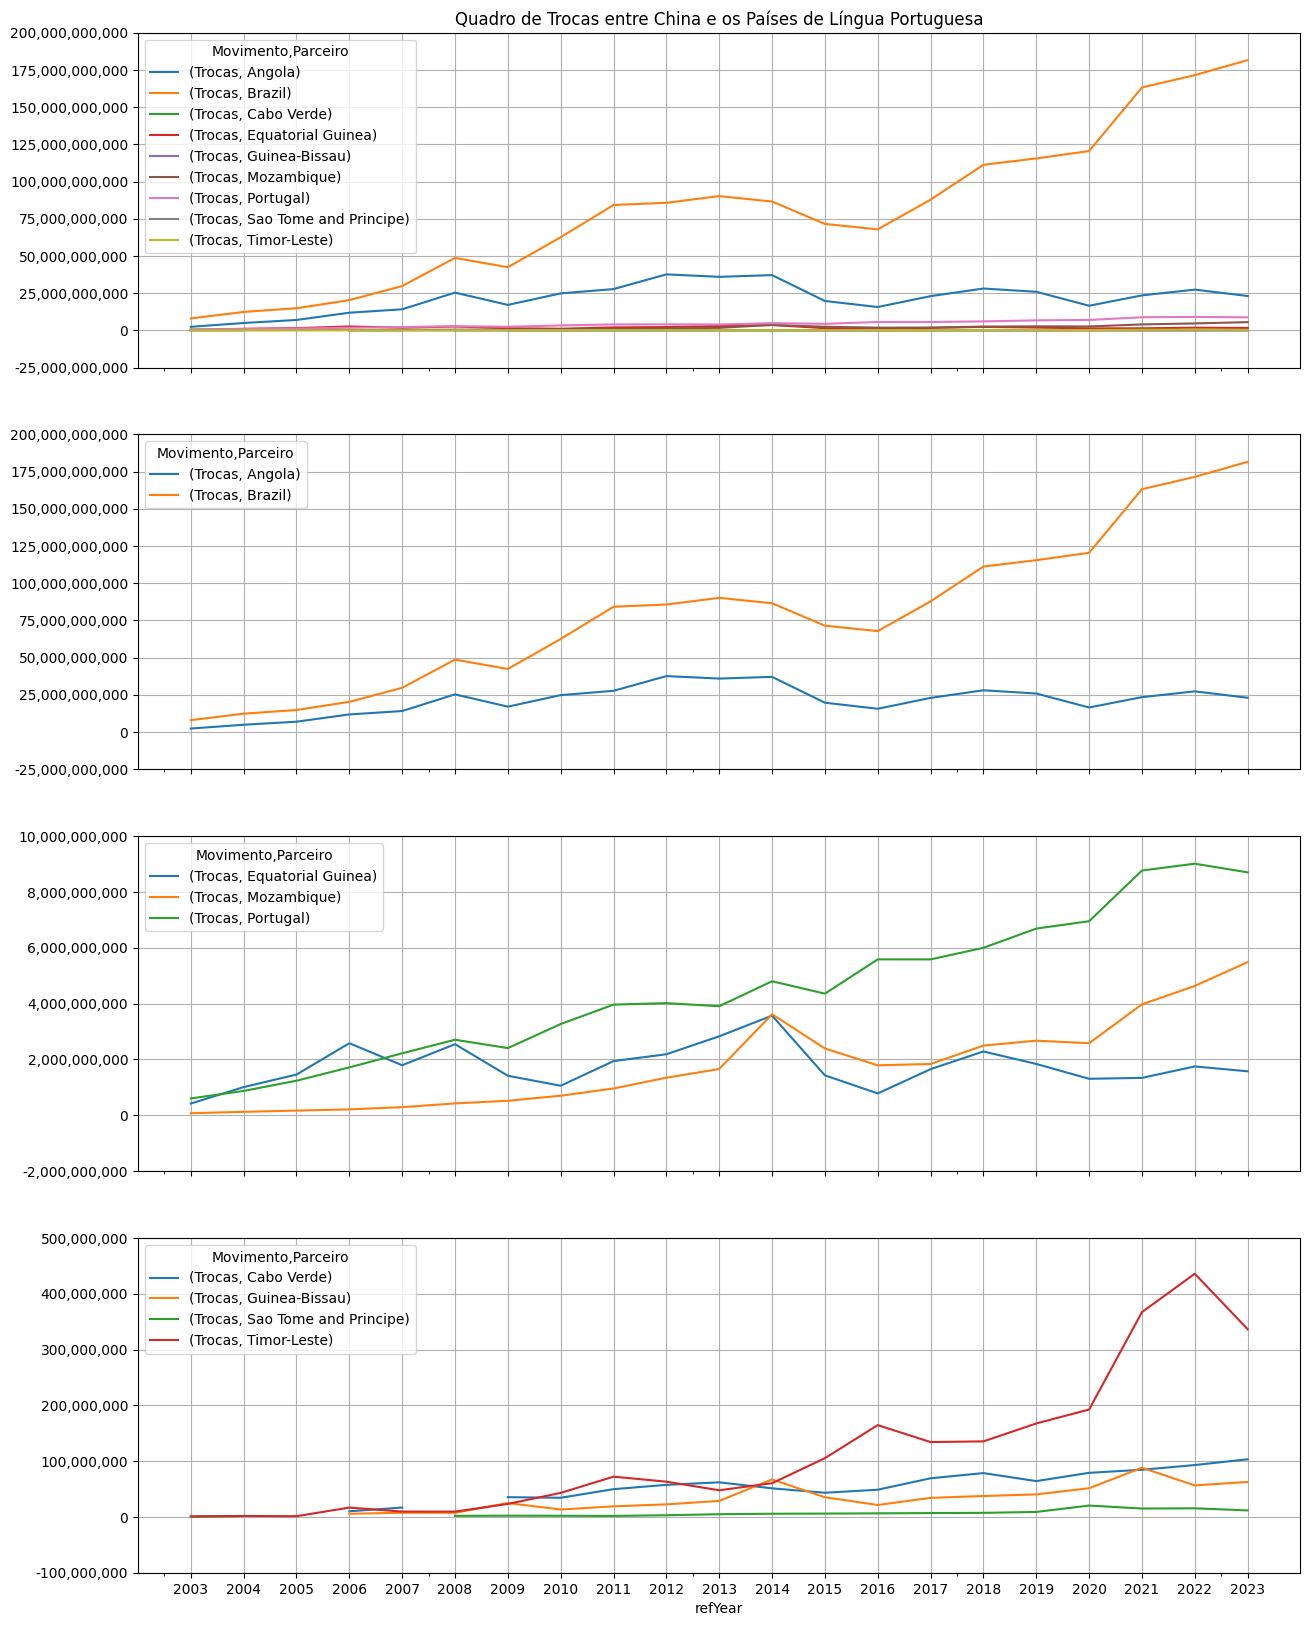

In [23]:
import matplotlib.pyplot as plt

title=f"Quadro de {movimento} entre {comtrade.COUNTRY_CODES[comtrade.m49_china]} e os Países de Língua Portuguesa"

# Define the line styles
line_styles = ['-', '--', '-.', ':']

size=(15,20)
figure,axis = plt.subplots(4,sharex=True,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cabo Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticks(current_values)
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"reports/cn_plp_{movimento}.png")

### Gráficos importações

In [24]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Importações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento       Importações                                                    \
Parceiro             Angola             Brazil   Cabo Verde Equatorial Guinea   
refYear                                                                         
2003       2,205,934,880.00   5,842,291,688.00       353.00    411,886,532.00   
2004       4,717,339,146.00   8,672,861,322.00          NaN    996,649,809.00   
2005       6,581,828,714.00   9,992,524,117.00          NaN  1,437,833,974.00   
2006      10,933,295,107.00  12,909,495,161.00       344.00  2,537,591,664.00   
2007      12,888,664,603.00  18,342,070,986.00        50.00  1,697,283,346.00   
2008      22,382,523,829.00  29,863,442,631.00          NaN  2,267,871,882.00   
2009      14,675,830,702.00  28,280,982,512.00       193.00  1,055,071,473.00   
2010      22,815,049,454.00  38,099,447,351.00    12,060.00    598,657,025.00   
2011      24,922,180,492.00  52,386,750,280.00    12,062.00  1,672,947,440.00   
2012      33,561,896,917.00  52,281,126,771.00     1,115.00  1,822,803,333.00   
2013      31,972,669,347.00  54,299,122,653.00       160.00  2,469,917,950.00   
2014      31,106,015,046.00  51,653,224,893.00     3,020.00  3,217,190,248.00   
2015      16,001,611,383.00  44,089,358,062.00    22,606.00  1,166,496,464.00   
2016      13,966,117,080.00  45,855,047,246.00    83,281.00    631,851,506.00   
2017      20,698,709,467.00  58,857,155,273.00     8,010.00  1,483,835,026.00   
2018      25,826,510,355.00  77,569,499,985.00   290,397.00  2,139,372,096.00   
2019      23,837,402,142.00  79,962,547,047.00    28,691.00  1,723,064,057.00   
2020      14,757,730,338.00  85,517,209,220.00 1,209,992.00  1,182,549,225.00   
2021      21,027,427,353.00 109,944,552,097.00 1,146,922.00  1,215,192,615.00   
2022      23,245,987,158.00 109,522,043,335.00    20,486.00  1,516,383,585.00   
2023      18,911,371,439.00 122,490,613,944.00    72,199.00  1,371,085,246.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
2003                NaN    26,591,793.00   194,613,740.00   
2004          29,251.00    44,286,108.00   280,896,511.00   
2005                NaN    73,527,324.00   323,834,266.00   
2006              64.00    79,772,228.00   353,809,128.00   
2007         172,994.00   124,248,069.00   384,642,280.00   
2008       1,242,562.00   125,882,374.00   387,489,834.00   
2009       1,617,183.00   177,554,369.00   480,929,852.00   
2010       3,862,870.00   201,077,529.00   754,426,018.00   
2011       4,112,691.00   257,241,199.00 1,162,063,935.00   
2012       6,633,460.00   403,320,479.00 1,514,582,001.00   
2013      16,827,743.00   454,874,745.00 1,399,460,781.00   
2014      49,956,236.00 1,649,822,358.00 1,663,291,480.00   
2015      17,812,428.00   452,616,050.00 1,461,543,018.00   
2016         161,227.00   479,356,871.00 1,582,818,088.00   
2017         402,375.00   528,715,219.00 2,139,178,524.00   
2018       7,638,682.00   633,533,508.00 2,249,055,585.00   
2019       8,402,360.00   713,241,603.00 2,322,314,576.00   
2020           5,381.00   579,498,619.00 2,772,488,349.00   
2021           1,111.00 1,144,564,129.00 3,451,149,913.00   
2022           2,563.00 1,340,115,953.00 3,036,088,177.00   
2023           1,533.00 1,770,862,046.00 2,912,033,496.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2003                  29,404.00          62.00  
2004               1,337,546.00          89.00  
2005                        NaN         716.00  
2006                        NaN  10,964,132.00  
2007                        NaN      49,480.00  
2008                  17,127.00     106,162.00  
2009                   4,280.00      22,765.00  
2010                  10,397.00     250,487.00  
2011                   1,639.00   1,742,791.00  
20

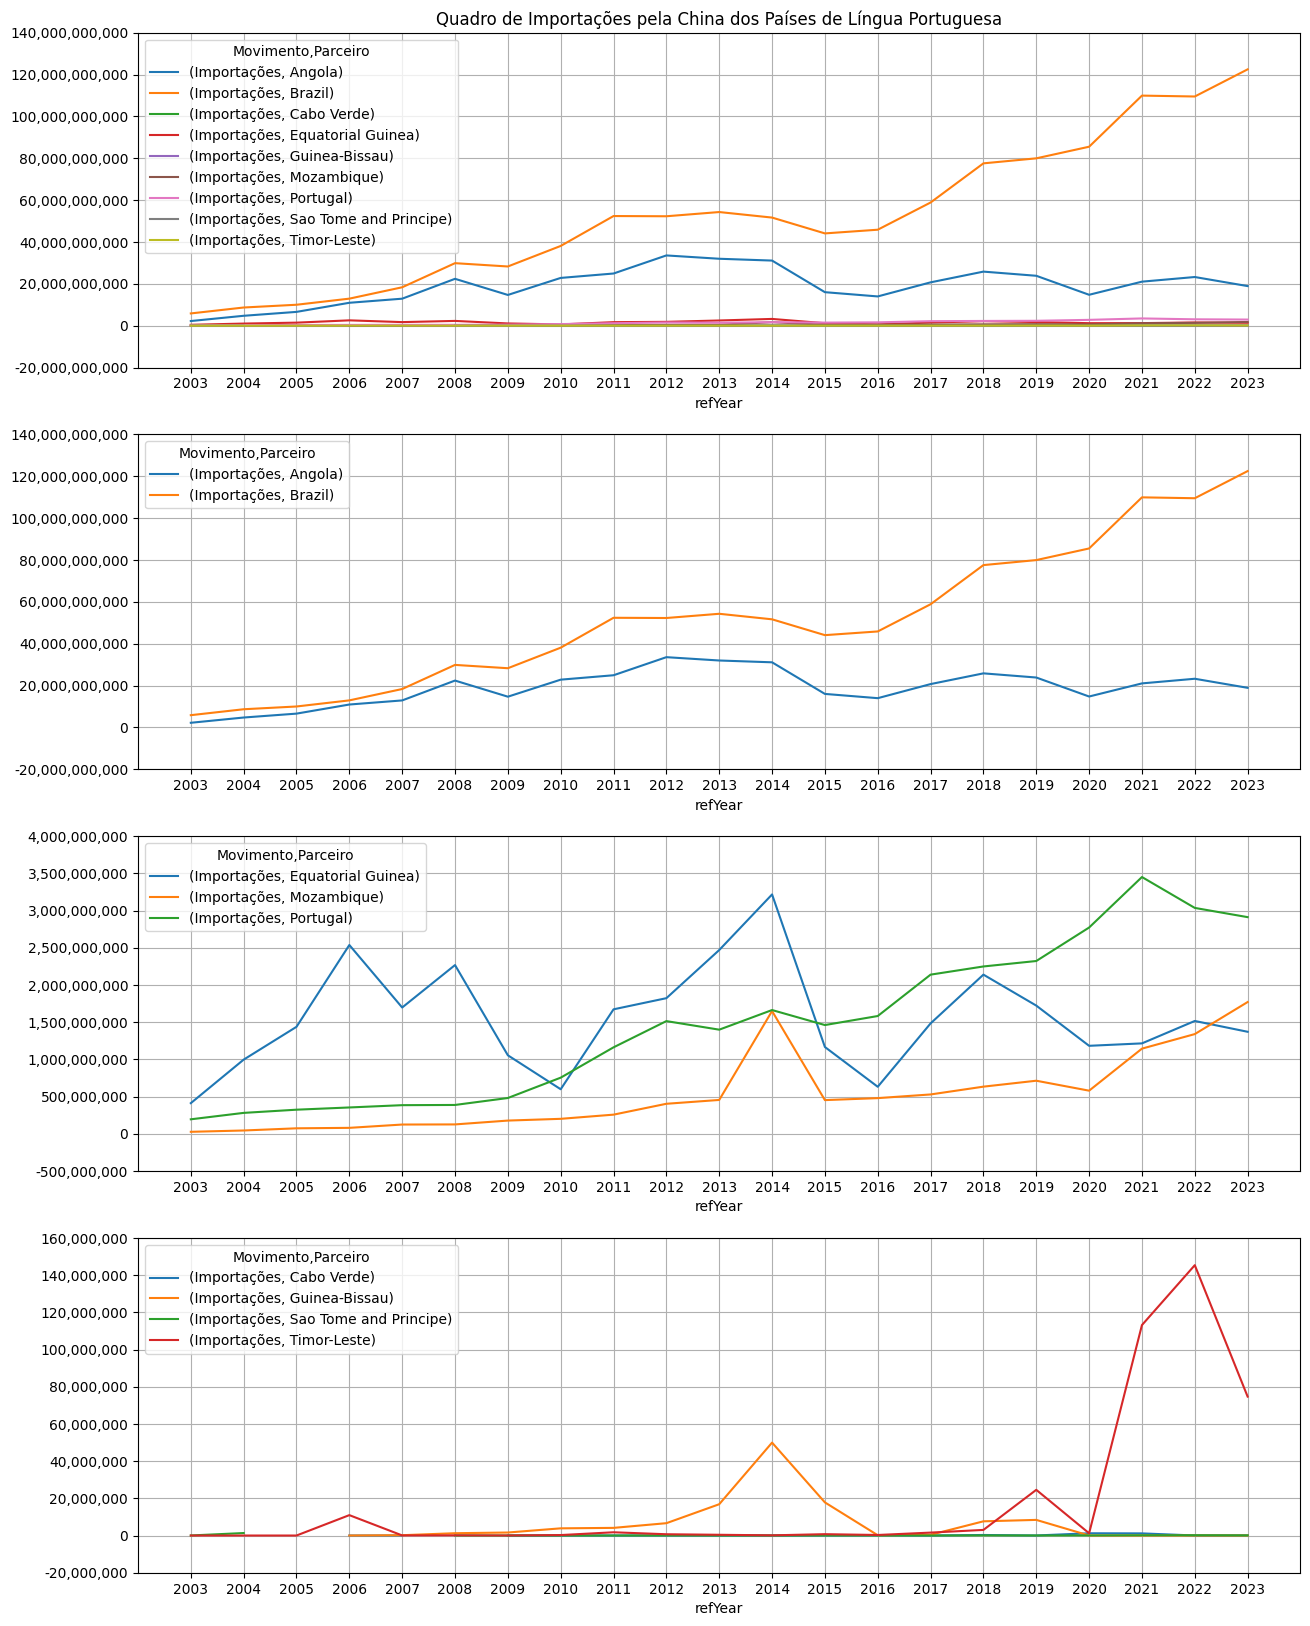

In [25]:
title=f"Quadro de {movimento} pela {comtrade.COUNTRY_CODES[comtrade.m49_china]} dos Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=False,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cabo Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticks(current_values)
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"reports/cn_plp_{movimento}.png")

### Gráficos exportações

In [26]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Exportações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento      Exportações                                                     \
Parceiro            Angola            Brazil     Cabo Verde Equatorial Guinea   
refYear                                                                         
2003        145,791,215.00  2,143,255,914.00   2,596,097.00      5,048,022.00   
2004        193,517,905.00  3,674,104,212.00   2,746,211.00     10,124,623.00   
2005        372,793,946.00  4,827,209,396.00   5,187,788.00     18,801,431.00   
2006        894,185,633.00  7,380,105,731.00  10,094,090.00     41,107,988.00   
2007      1,234,518,651.00 11,398,472,406.00  16,826,488.00     92,790,802.00   
2008      2,942,469,756.00 18,807,457,292.00  14,953,954.00    277,390,904.00   
2009      2,385,960,008.00 14,118,518,263.00  35,405,032.00    358,423,820.00   
2010      2,003,872,576.00 24,460,651,866.00  34,335,093.00    456,241,241.00   
2011      2,784,153,366.00 31,836,677,325.00  49,751,685.00    266,317,114.00   
2012      4,039,171,270.00 33,413,633,342.00  57,490,473.00    361,434,154.00   
2013      3,964,058,933.00 35,895,471,244.00  61,996,094.00    357,517,241.00   
2014      5,974,996,819.00 34,890,134,489.00  51,223,437.00    352,515,328.00   
2015      3,717,145,883.00 27,412,225,426.00  43,300,195.00    261,389,919.00   
2016      1,680,398,624.00 21,976,152,765.00  48,671,438.00    148,253,831.00   
2017      2,257,453,225.00 28,950,538,235.00  69,239,870.00    166,217,956.00   
2018      2,253,137,107.00 33,665,139,187.00  78,265,751.00    145,146,401.00   
2019      2,055,727,417.00 35,539,063,912.00  64,166,991.00    113,204,451.00   
2020      1,748,092,204.00 34,953,227,525.00  77,836,679.00    122,120,216.00   
2021      2,437,309,104.00 53,258,848,788.00  83,385,009.00    122,333,747.00   
2022      4,096,911,182.00 61,969,970,590.00  92,964,632.00    230,727,369.00   
2023      4,141,201,134.00 59,105,409,511.00 103,216,267.00    201,839,875.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
2003      12,350,232.00    45,028,314.00   406,256,461.00   
2004       5,994,304.00    75,154,316.00   588,259,140.00   
2005       5,793,889.00    91,477,874.00   911,952,506.00   
2006       5,677,056.00   127,940,363.00 1,359,664,205.00   
2007       7,308,823.00   163,552,940.00 1,834,752,144.00   
2008       6,146,998.00   295,994,949.00 2,317,102,263.00   
2009      23,193,644.00   339,133,810.00 1,923,516,206.00   
2010       9,433,700.00   496,391,036.00 2,513,317,692.00   
2011      14,850,937.00   700,247,026.00 2,801,433,742.00   
2012      15,894,649.00   940,887,034.00 2,501,157,554.00   
2013      11,889,575.00 1,199,293,242.00 2,506,863,699.00   
2014      17,153,183.00 1,968,739,789.00 3,137,073,216.00   
2015      17,482,677.00 1,938,023,358.00 2,894,923,138.00   
2016      21,236,460.00 1,308,557,797.00 4,002,119,526.00   
2017      33,724,346.00 1,306,746,135.00 3,445,214,944.00   
2018      29,831,705.00 1,861,780,970.00 3,750,198,143.00   
2019      31,938,678.00 1,957,695,041.00 4,366,438,258.00   
2020      51,430,636.00 2,000,068,552.00 4,180,565,068.00   
2021      88,099,385.00 2,828,107,658.00 5,318,431,959.00   
2022      56,515,898.00 3,292,124,290.00 5,978,101,967.00   
2023      62,694,163.00 3,715,538,051.00 5,792,299,358.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2003                 199,397.00   1,067,053.00  
2004                 222,785.00   1,708,545.00  
2005                 550,025.00   1,272,825.00  
2006               1,217,928.00   5,794,277.00  
2007               1,796,699.00   9,519,753.00  
2008               1,887,730.00   9,426,360.00  
2009               2,197,926.00  23,260,240.00  
2010               2,054,289.00  42,832,008.00  
2011               1,792,170.00  70,432,762.00  
20

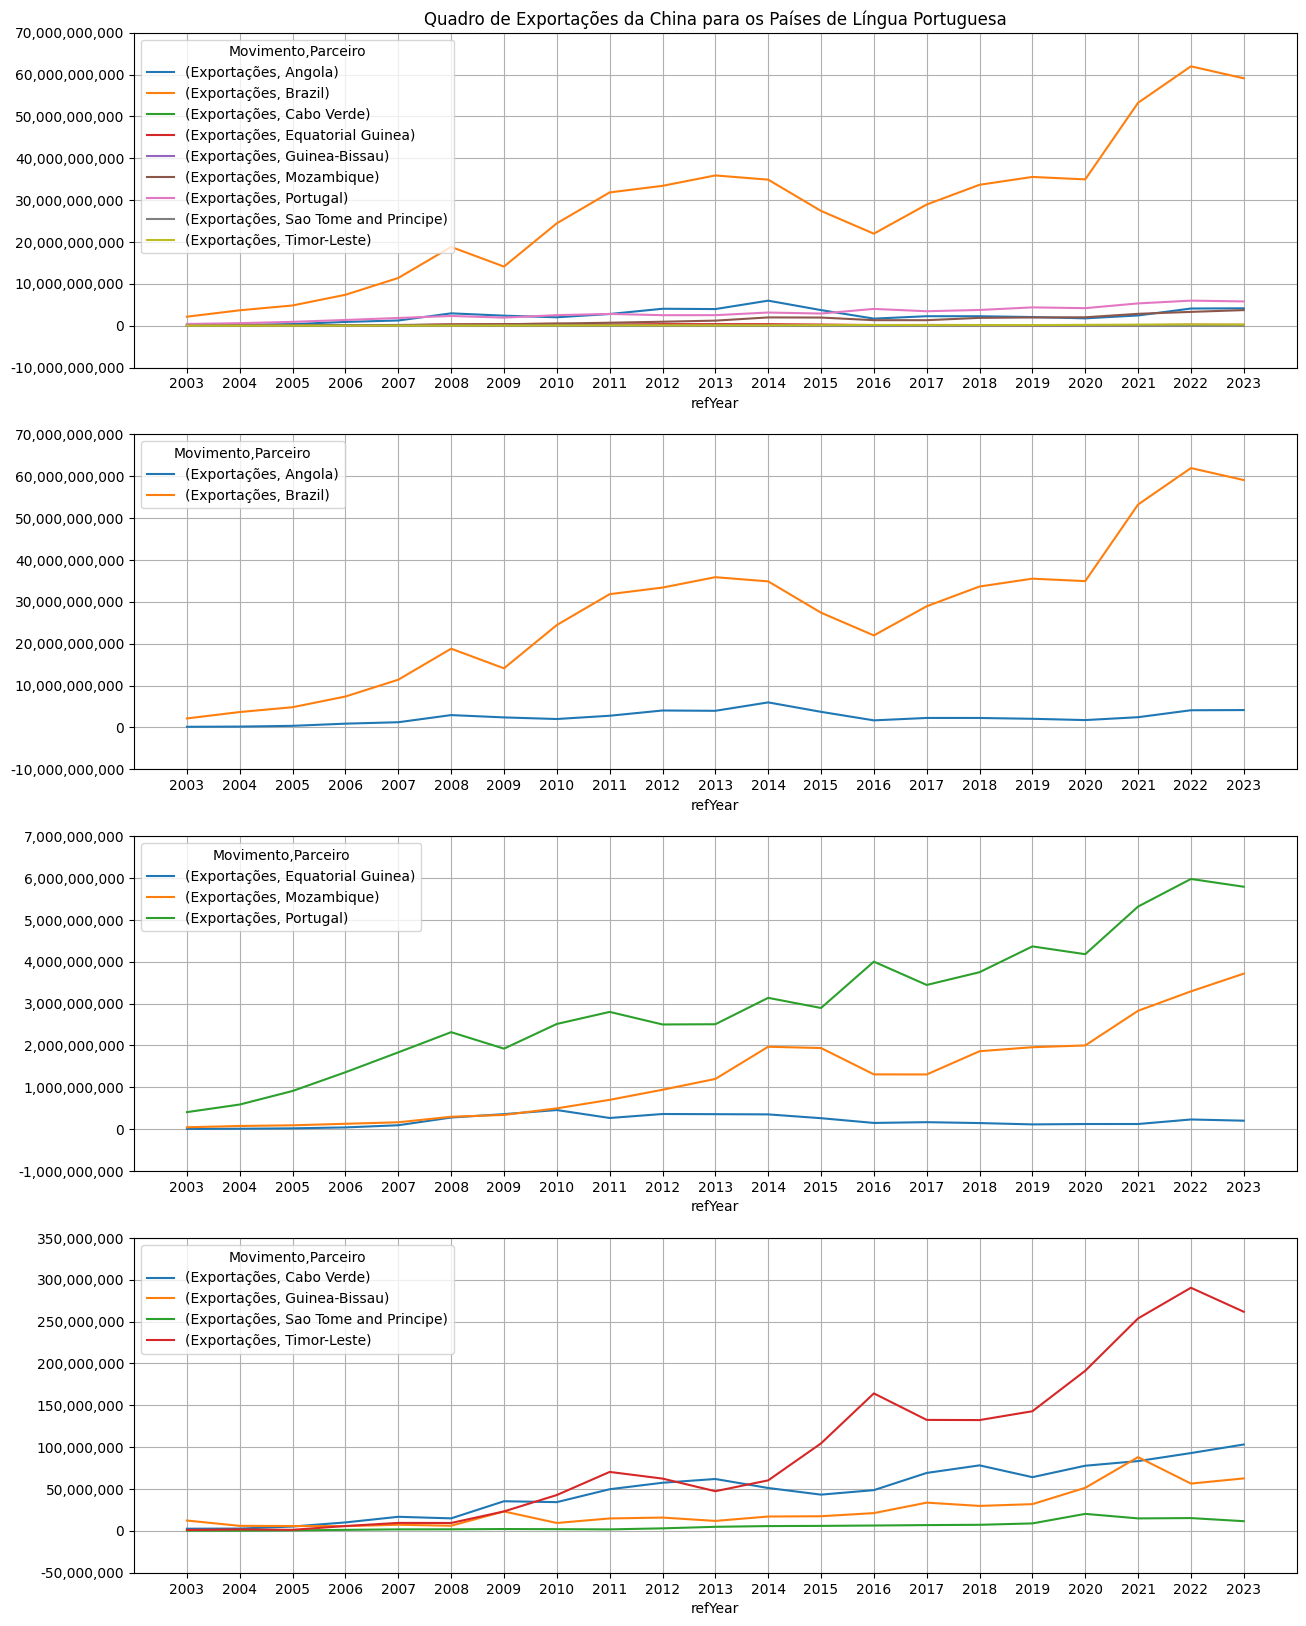

In [27]:
title=f"Quadro de {movimento} da {comtrade.COUNTRY_CODES[comtrade.m49_china]} para os Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=False,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cabo Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticks(current_values)
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"reports/cn_plp_{movimento}.png")

### Gráficos saldo (China: exportações-importações)

In [28]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Saldo' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento              Saldo                                    \
Parceiro              Angola             Brazil     Cabo Verde   
refYear                                                          
2003       -2,060,143,665.00  -3,699,035,774.00   2,595,744.00   
2004       -4,523,821,241.00  -4,998,757,110.00            NaN   
2005       -6,209,034,768.00  -5,165,314,721.00            NaN   
2006      -10,039,109,474.00  -5,529,389,430.00  10,093,746.00   
2007      -11,654,145,952.00  -6,943,598,580.00  16,826,438.00   
2008      -19,440,054,073.00 -11,055,985,339.00            NaN   
2009      -12,289,870,694.00 -14,162,464,249.00  35,404,839.00   
2010      -20,811,176,878.00 -13,638,795,485.00  34,323,033.00   
2011      -22,138,027,126.00 -20,550,072,955.00  49,739,623.00   
2012      -29,522,725,647.00 -18,867,493,429.00  57,489,358.00   
2013      -28,008,610,414.00 -18,403,651,409.00  61,995,934.00   
2014      -25,131,018,227.00 -16,763,090,404.00  51,220,417.00   
2015      -12,284,465,500.00 -16,677,132,636.00  43,277,589.00   
2016      -12,285,718,456.00 -23,878,894,481.00  48,588,157.00   
2017      -18,441,256,242.00 -29,906,617,038.00  69,231,860.00   
2018      -23,573,373,248.00 -43,904,360,798.00  77,975,354.00   
2019      -21,781,674,725.00 -44,423,483,135.00  64,138,300.00   
2020      -13,009,638,134.00 -50,563,981,695.00  76,626,687.00   
2021      -18,590,118,249.00 -56,685,703,309.00  82,238,087.00   
2022      -19,149,075,976.00 -47,552,072,745.00  92,944,146.00   
2023      -14,770,170,305.00 -63,385,204,433.00 103,144,068.00   

Movimento                                                                     \
Parceiro  Equatorial Guinea  Guinea-Bissau       Mozambique         Portugal   
refYear                                                                        
2003        -406,838,510.00            NaN    18,436,521.00   211,642,721.00   
2004        -986,525,186.00   5,965,053.00    30,868,208.00   307,362,629.00   
2005      -1,419,032,543.00            NaN    17,950,550.00   588,118,240.00   
2006      -2,496,483,676.00   5,676,992.00    48,168,135.00 1,005,855,077.00   
2007      -1,604,492,544.00   7,135,829.00    39,304,871.00 1,450,109,864.00   
2008      -1,990,480,978.00   4,904,436.00   170,112,575.00 1,929,612,429.00   
2009        -696,647,653.00  21,576,461.00   161,579,441.00 1,442,586,354.00   
2010        -142,415,784.00   5,570,830.00   295,313,507.00 1,758,891,674.00   
2011      -1,406,630,326.00  10,738,246.00   443,005,827.00 1,639,369,807.00   
2012      -1,461,369,179.00   9,261,189.00   537,566,555.00   986,575,553.00   
2013      -2,112,400,709.00  -4,938,168.00   744,418,497.00 1,107,402,918.00   
2014      -2,864,674,920.00 -32,803,053.00   318,917,431.00 1,473,781,736.00   
2015        -905,106,545.00    -329,751.00 1,485,407,308.00 1,433,380,120.00   
2016        -483,597,675.00  21,075,233.00   829,200,926.00 2,419,301,438.00   
2017      -1,317,617,070.00  33,321,971.00   778,030,916.00 1,306,036,420.00   
2018      -1,994,225,695.00  22,193,023.00 1,228,247,462.00 1,501,142,558.00   
2019      -1,609,859,606.00  23,536,318.00 1,244,453,438.00 2,044,123,682.00   
2020      -1,060,429,009.00  51,425,255.00 1,420,569,933.00 1,408,076,719.00   
2021      -1,092,858,868.00  88,098,274.00 1,683,543,529.00 1,867,282,046.00   
2022      -1,285,656,216.00  56,513,335.00 1,952,008,337.00 2,942,013,790.00   
2023      -1,169,245,371.00  62,692,630.00 1,944,676,005.00 2,880,265,862.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2003                 169,993.00   1,066,991.00  
2004              -1,114,761.00   1,708,456.00  
2005                        NaN   1,272,109.00  
2006                        NaN  -5,169,855.00  
2007                        NaN   9,470,273.00  
2008               1,870,603.00   9,320,198.00  
2009               2,193,646.00  23,237,475.00  
2010

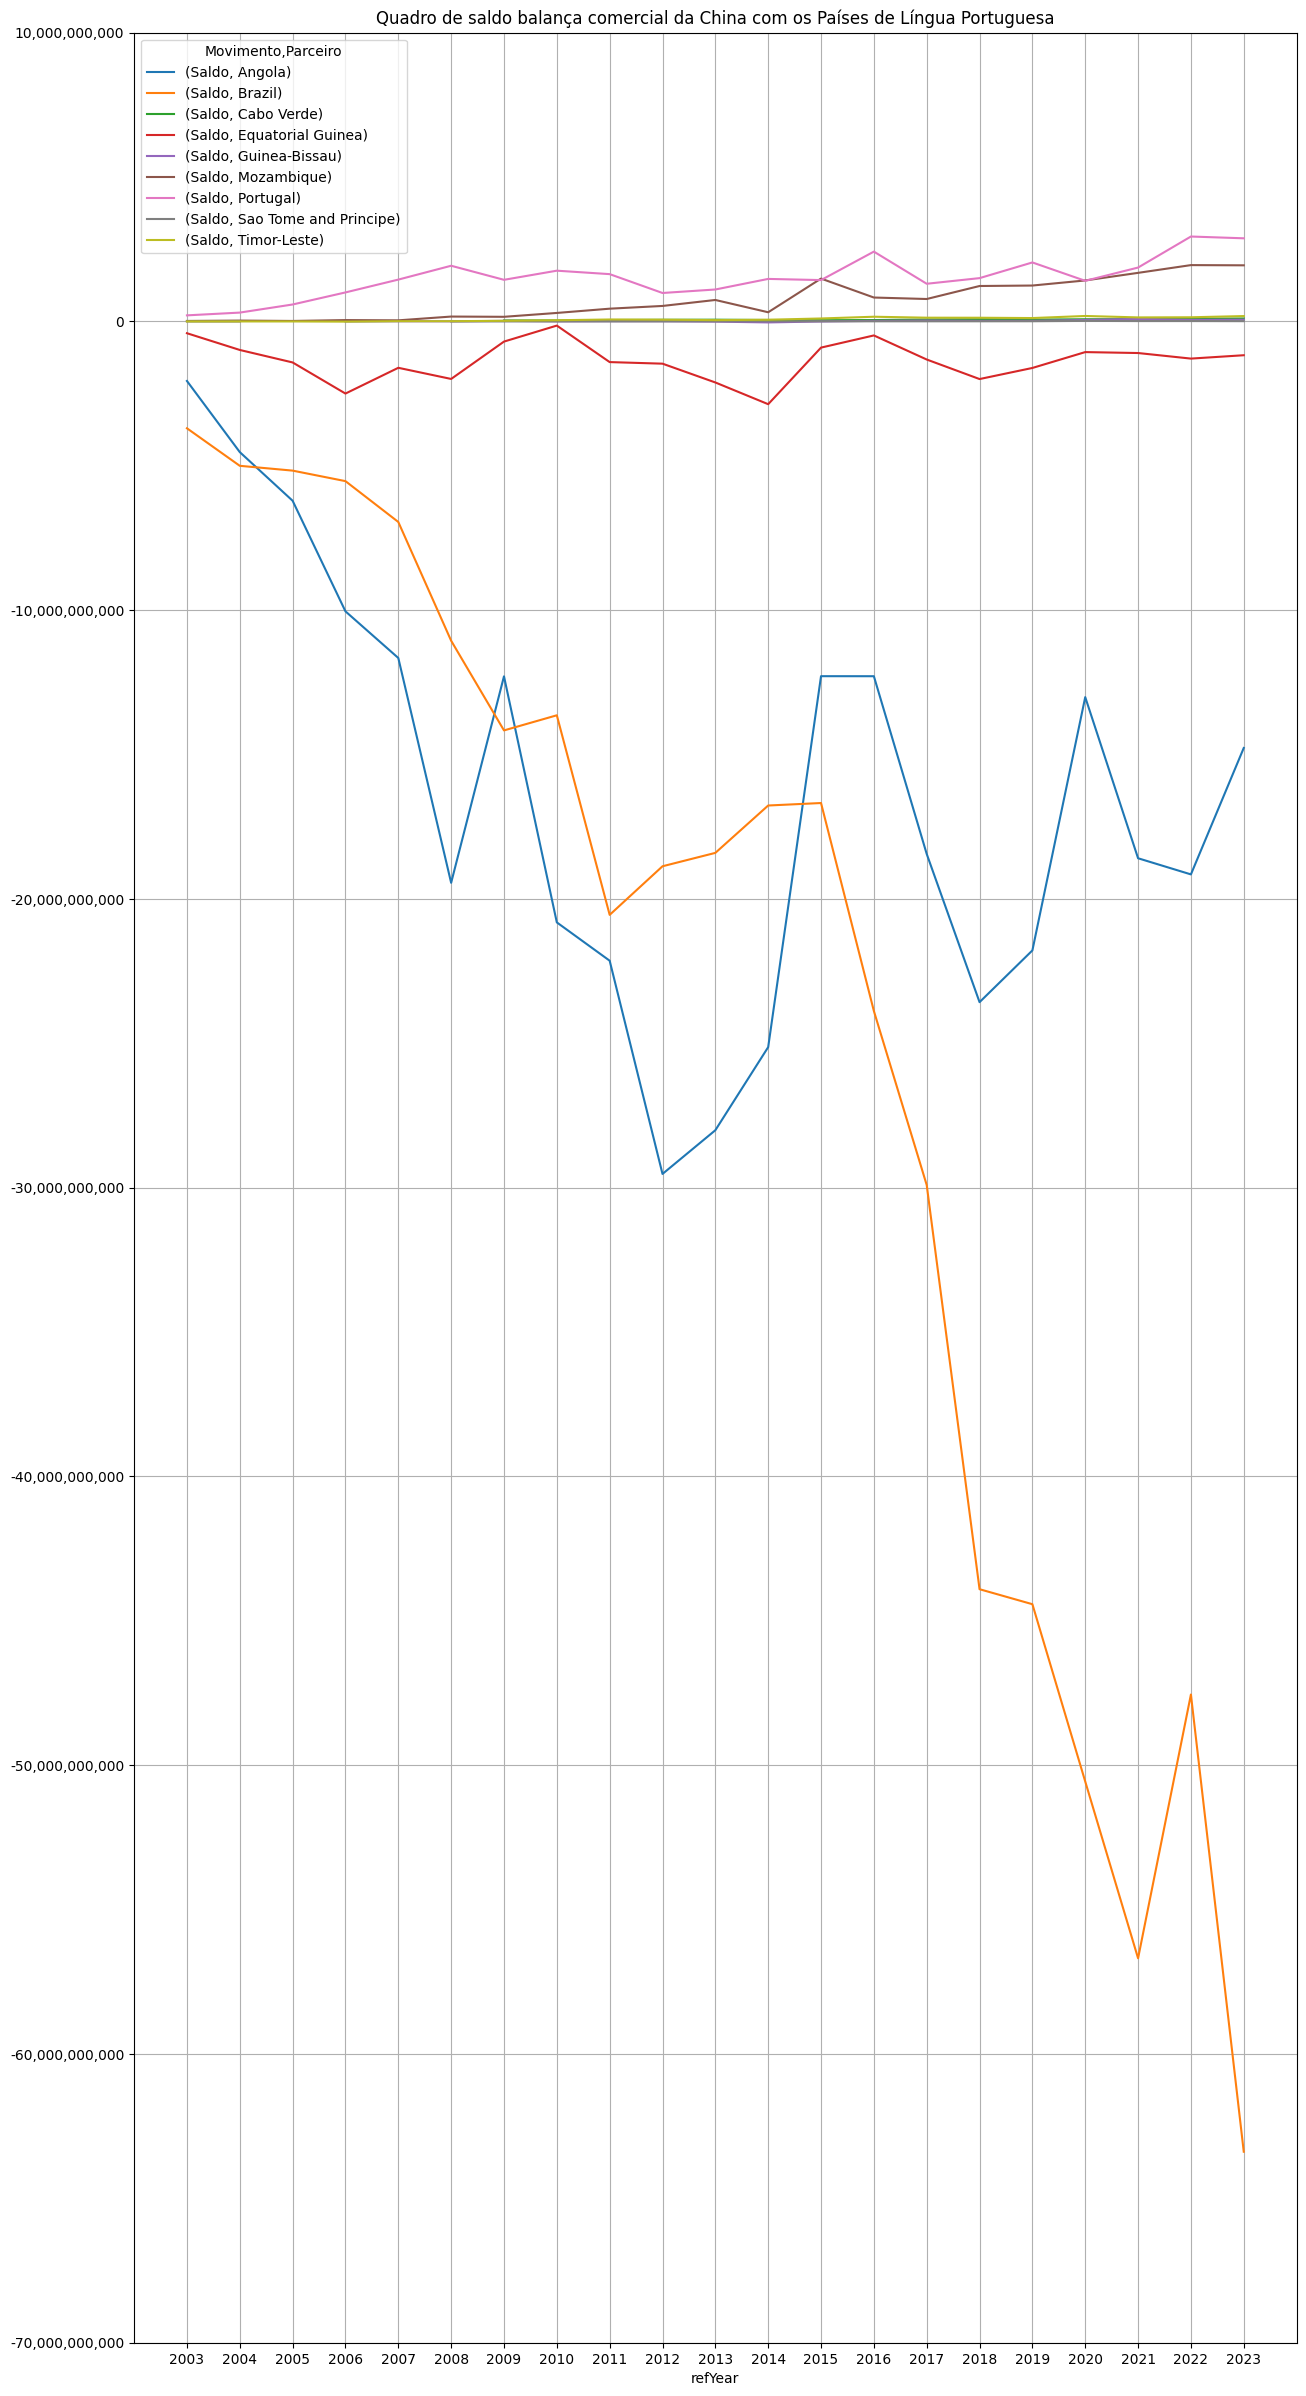

In [31]:
import matplotlib.pyplot as plt

title=f"Quadro de saldo balança comercial da {comtrade.COUNTRY_CODES[comtrade.m49_china]} com os Países de Língua Portuguesa"
ax = graph_data.plot.line(figsize=(15,30),xticks=graph_data.index.values,title=title)

current_values = ax.get_yticks()
ax.set_yticks(current_values)
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
ax.grid()
plt.savefig(f"reports/cn_plp_{movimento}.png")

In [32]:
import datetime
# print the current date and time


print("Current date and time: ", datetime.datetime.now())

Current date and time:  2024-06-12 11:07:53.088532
